# German Credit Bias Analysis with AI Fairness 360

This notebook loads the German Credit dataset, computes baseline fairness metrics, applies a bias mitigation algorithm (Reweighing), and compares metrics before and after mitigation. It saves comparison charts and CSV outputs under `results/`.



             metric  original  mitigated
0          accuracy  0.753333   0.760000
1           roc_auc  0.807745   0.810619
2  stat_parity_diff -0.221350  -0.099097
3  disparate_impact  0.735460   0.876286
4    equal_opp_diff -0.152747  -0.058701
5     avg_odds_diff -0.235020  -0.095766


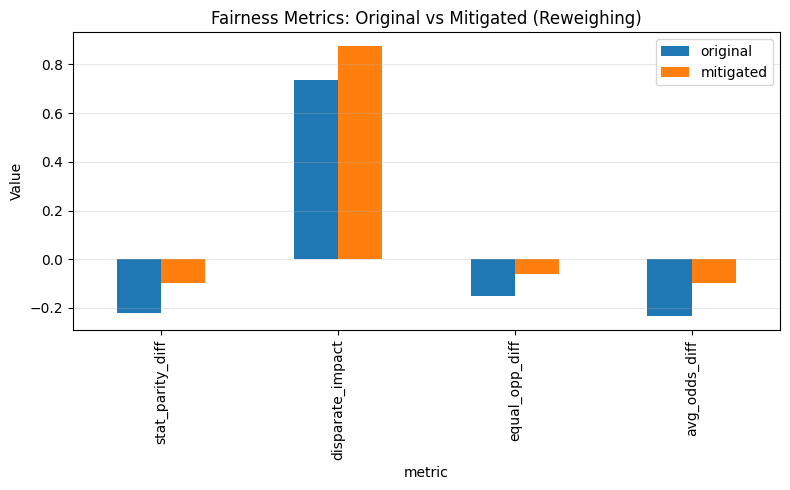

Saved comparison figure to ../results/screenshots/fairness_metrics_comparison.png


In [5]:
# 1. Environment setup (already handled by requirements.txt & venv)
import os, random, sys
import numpy as np
np.random.seed(42)
random.seed(42)

# Core imports
import aif360
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

import pandas as pd
import matplotlib.pyplot as plt

# Paths
os.makedirs('../results/screenshots', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# 2. Load German Credit dataset using defaults to ensure proper encoding
# GermanDataset handles categorical encoding and age binarization internally.
dataset = GermanDataset()

# Protected attribute and groups
protected_attr = dataset.protected_attribute_names[0]  # 'age'
privileged_groups = [{protected_attr: 1}]
unprivileged_groups = [{protected_attr: 0}]

# 3. Train/test split
train, test = dataset.split([0.7], shuffle=True)

# Helper to build and train a simple classifier
def build_model():
    clf = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('lr', LogisticRegression(max_iter=1000, solver='liblinear'))
    ])
    return clf

def to_numpy(binary_ds):
    return binary_ds.features, binary_ds.labels.ravel()

# 4. Baseline model
X_train, y_train = to_numpy(train)
X_test, y_test = to_numpy(test)
model = build_model()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

baseline_acc = accuracy_score(y_test, y_pred)
baseline_auc = roc_auc_score(y_test, y_scores)

# 5. Fairness metrics (baseline)
test_pred_ds = test.copy()
test_pred_ds.labels = y_pred.reshape(-1, 1)

metric_baseline = ClassificationMetric(test, test_pred_ds,
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)

sp_diff_pred = metric_baseline.statistical_parity_difference()
di_pred = metric_baseline.disparate_impact()
eod = metric_baseline.equal_opportunity_difference()
aod = metric_baseline.average_odds_difference()

# 6. Mitigation: Reweighing
rw = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
train_rw = rw.fit_transform(train)
X_train_rw, y_train_rw = to_numpy(train_rw)

model_rw = build_model()
# pass instance weights to the logistic regression via pipeline param name
model_rw.fit(X_train_rw, y_train_rw, lr__sample_weight=train_rw.instance_weights)

y_pred_rw = model_rw.predict(X_test)
y_scores_rw = model_rw.predict_proba(X_test)[:, 1] if hasattr(model_rw, 'predict_proba') else y_pred_rw

acc_rw = accuracy_score(y_test, y_pred_rw)
auc_rw = roc_auc_score(y_test, y_scores_rw)

test_pred_rw_ds = test.copy()
test_pred_rw_ds.labels = y_pred_rw.reshape(-1, 1)

metric_rw = ClassificationMetric(test, test_pred_rw_ds,
                                 unprivileged_groups=unprivileged_groups,
                                 privileged_groups=privileged_groups)

sp_diff_rw = metric_rw.statistical_parity_difference()
di_rw = metric_rw.disparate_impact()
eod_rw = metric_rw.equal_opportunity_difference()
aod_rw = metric_rw.average_odds_difference()

# 7. Summary table and save CSV
summary = pd.DataFrame({
    'metric': ['accuracy', 'roc_auc', 'stat_parity_diff', 'disparate_impact', 'equal_opp_diff', 'avg_odds_diff'],
    'original': [baseline_acc, baseline_auc, sp_diff_pred, di_pred, eod, aod],
    'mitigated': [acc_rw, auc_rw, sp_diff_rw, di_rw, eod_rw, aod_rw]
})
summary.to_csv('../results/german_credit_fairness_summary.csv', index=False)
print(summary)

# 8. Plot comparison and save screenshots
metrics_to_plot = ['stat_parity_diff', 'disparate_impact', 'equal_opp_diff', 'avg_odds_diff']
data_plot = summary[summary['metric'].isin(metrics_to_plot)].set_index('metric')

fig, ax = plt.subplots(figsize=(8, 5))
data_plot.plot(kind='bar', ax=ax)
ax.set_title('Fairness Metrics: Original vs Mitigated (Reweighing)')
ax.set_ylabel('Value')
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
figpath = '../results/screenshots/fairness_metrics_comparison.png'
plt.savefig(figpath, dpi=160)
plt.show()
print(f'Saved comparison figure to {figpath}')